## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Michael Pyrcz, Carlos Torres-Verdin, 2024
***

In [ ]:
from main import *
ari = ARI()
case1, case2 = ari.load_data()

In [ ]:
inv1 = ari.resistivity_inversion(case1, lambda_reg=1e-6, Wd_matrix=True, tolerance=1e-6, maxiter=1e3, 
                                    x0=[0.5, 1.5], Rvsh=2.8133, Rhsh=0.7746, 
                                    method='CG', bounds=None)
ari.plot_inversion_results(inv1, figsize=(20,12))

In [ ]:
inv2 = ari.resistivity_inversion(case2, lambda_reg=1e-6, Wd_matrix=True, tolerance=1e-6, maxiter=1e3, 
                                    x0=[0.5, 1.5], Rvsh=4.0431, Rhsh=0.6742, 
                                    method='CG', bounds=None)
ari.plot_inversion_results(inv2, figsize=(20,12))

In [ ]:
inv1 = ari.resistivity_inversion(case1, lambda_reg=1e-6, Wd_matrix=True, tolerance=1e-6, maxiter=1e3, 
                                    x0=[0.5, 1.5], Rvsh=2.8133, Rhsh=0.7746, 
                                    method='L-BFGS-B', bounds=[(0,1),(None,None)])
ari.plot_inversion_results(inv1, figsize=(20,12))

In [ ]:
inv2 = ari.resistivity_inversion(case2, lambda_reg=1e-6, Wd_matrix=True, tolerance=1e-6, maxiter=1e3, 
                                    x0=[0.5, 1.5], Rvsh=4.0431, Rhsh=0.6742, 
                                    method='L-BFGS-B', bounds=[(0,1),(None,None)])
ari.plot_inversion_results(inv2, figsize=(20,12))

In [ ]:
case1_qinv = ari.quadratic_inversion(case1)
case2_qinv = ari.quadratic_inversion(case2)

***
# Physics-Informed Neural Network
***

In [1]:
from main import *
ari = ARI()
case1, case2 = ari.load_data()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.2.0 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------



In [2]:
class PINNari(nn.Module):
    def __init__(self):
        super(PINNari, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 2)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [3]:
class PhysicsLoss(nn.Module):
    def __init__(self, model, Rvsh, Rhsh):
        super(PhysicsLoss, self).__init__()
        self.model = model
        self.Rvsh = Rvsh
        self.Rhsh = Rhsh

    def forward(self, Rv_true, Rh_true):
        Csh, Rs = self.model(torch.tensor([Rv_true, Rh_true], dtype=torch.float32))
        Csh = torch.sigmoid(Csh) #Csh in [0,1]
        Rs  = torch.abs(Rs)      #Rs in [0,inf)

        eq1 = (Csh*self.Rvsh + (1-Csh)*Rs) - Rv_true
        eq2 = (Csh/self.Rhsh + (1-Csh)/Rs) - (1/Rh_true)
        eq1 = eq1.unsqueeze(0) if eq1.dim()==0 else eq1
        eq2 = eq2.unsqueeze(0) if eq2.dim()==0 else eq2
        eqs = torch.cat((eq1/Rv_true, eq2*Rh_true), dim=0)

        return torch.norm(eqs, p=2)

In [4]:
res_aniso = case1[['Rv','Rh']]
Rvsh, Rhsh = 2.8133, 0.7746

model     = PINNari()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = PhysicsLoss(model, Rvsh, Rhsh)

epochs = 300
for _, row in res_aniso.iterrows():
    Rv_true, Rh_true = row['Rv'], row['Rh']
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = criterion(Rv_true, Rh_true)
        loss.backward()
        optimizer.step()

adjoints = {}
for name, param in model.named_parameters():
    if param.grad is not None:
        adjoints[name] = param.grad.clone().detach()

In [5]:
pred = model(torch.tensor(case1[['Rv','Rh']].values, dtype=torch.float32))
csh_pred = pred[:,1].detach().numpy()
rs_pred  = pred[:,0].detach().numpy()

Rv_sim = csh_pred * Rvsh + (1 - csh_pred) * rs_pred
Rh_sim = 1 / (csh_pred / Rhsh + (1 - csh_pred) / rs_pred)

sol = pd.DataFrame({'Csh_pred':csh_pred, 'Rs_pred':rs_pred, 'Rv_sim':Rv_sim, 'Rh_sim':1/Rh_sim}, index=case1.index)

/mnt/e/Anisotropic-Resistivity-Inversion/main.py:82: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xlim(lb, ub)


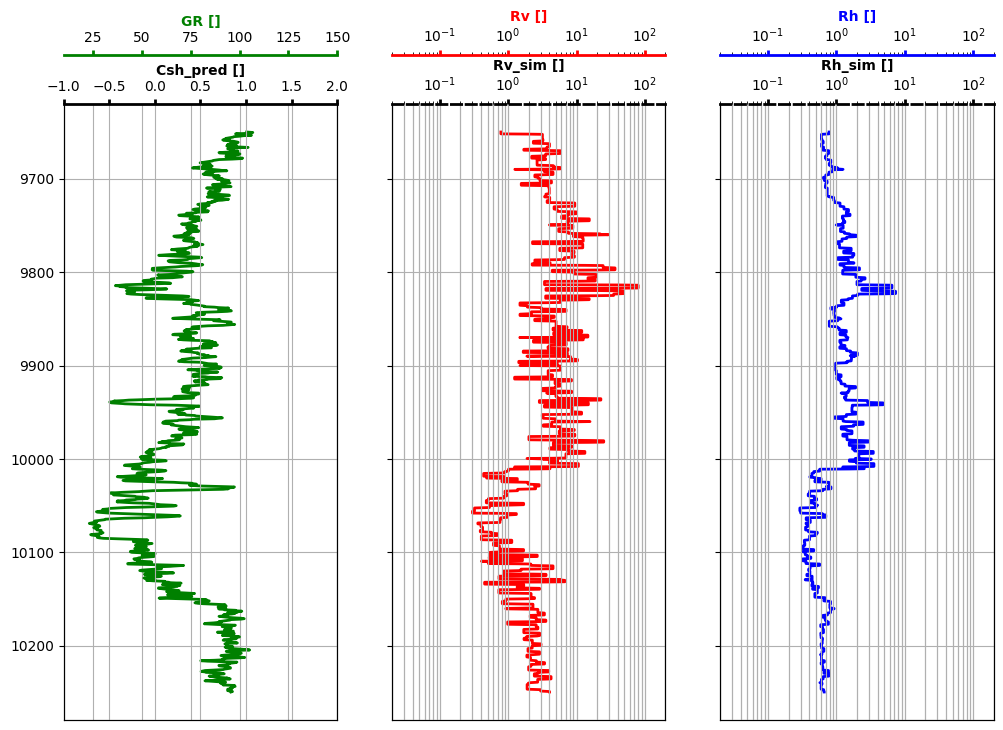

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(12,8), sharey=True)
ax1, ax2, ax3 = axs

ax11 = ax1.twiny()
ari.plot_curve(ax1, case1, 'GR', 10, 150, 'g', pad=8)
ari.plot_curve(ax11, sol, 'Csh_pred', -1, 2, 'k')

ax21 = ax2.twiny()
ari.plot_curve(ax2, case1, 'Rv', 0.02, 200, 'r', semilog=True, pad=8)
ari.plot_curve(ax21, sol, 'Rv_sim', 0.02, 200, 'k', ls='--', semilog=True)

ax31 = ax3.twiny()
ari.plot_curve(ax3, case1, 'Rh', 0.02, 200, 'b', semilog=True, pad=8)
ari.plot_curve(ax31, sol, 'Rh_sim', 0.02, 200, 'k', ls='--', semilog=True)

[ax.grid(True, which='both') for ax in axs]
ax1.invert_yaxis()
plt.show()

***
# END